In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import tensorflow as tf
import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [2]:
data_base = pd.read_excel("regression_avito_deals.xlsx")

data = data_base.sample(frac=0.1, random_state=123)


In [3]:
data

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability
20008,1d32ffe80550,f39abf77014f,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Другое,NaN,Детские вещи пакетом,Отдам детские вещи пакетом 300 руб.размер от 6...,300.0,10,2017-03-21,Private,0.00000
446970,c13b2c8a268e,1671b7e366e4,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,40,Сапоги,Зимние сапоги. Замш. На платформе... торг уместен,1500.0,14,2017-03-25,Private,0.00000
623076,627594210093,43aebc5caa96,Свердловская область,Екатеринбург,Хобби и отдых,Спорт и отдых,Другое,NaN,NaN,Брюки для бальных танцев,"Рост-90 см, обхват талии- 66 см",700.0,5,2017-03-19,Private,0.00000
283909,ea7601e8a8df,d30fdae30c67,Татарстан,Казань,Личные вещи,Часы и украшения,Бижутерия,NaN,NaN,Подставка для украшений,Продам бархатные подставки для украшений./\n9 ...,250.0,20,2017-03-27,Private,0.00000
340096,aa402705019b,c918b748b302,Кемеровская область,Новокузнецк,Для дома и дачи,Ремонт и строительство,Стройматериалы,NaN,NaN,Дом из бруса с верандой (6х6) м +2м,"Одноэтажный дом с жилым чердачным этажем, одно...",136300.0,32,2017-03-22,Company,0.38925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101577,32505edaf3a0,e0f91531f503,Пермский край,Пермь,Хобби и отдых,Книги и журналы,Учебная литература,NaN,NaN,Химия книга,NaN,100.0,59,2017-03-21,Company,0.00000
523166,c417bfffe4c5,6efaf97581c4,Ростовская область,Шахты,Личные вещи,Детская одежда и обувь,Для девочек,Комбинезоны и боди,86-92 см (1-2 года),Комбинезон зимний,Комбинезон зимний для девочки серый.,200.0,31,2017-03-21,Private,0.00000
579704,23391bf2fbb8,ec05047cd779,Омская область,Омск,Услуги,Предложение услуг,Другое,NaN,NaN,Ремонт автопластика,от 300 рублей ремонт зеркал,NaN,7,2017-03-17,Private,0.00000
445916,2b5d7b2f9cc5,6657c0ffdc22,Челябинская область,Челябинск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,NaN,NaN,Палантин,Размеры 176*110,300.0,13,2017-03-19,Private,0.00000


In [4]:
data.shape

(75171, 16)

In [5]:
data.columns


Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'deal_probability'],
      dtype='object')

In [6]:
data.describe(include='all')

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability
count,75171,75171,75171,75171,75171,75171,72053,42149,31816,75171,69455,7.084300e+04,75171.000000,75171,75171,75171.000000
unique,75171,66683,28,1129,9,47,328,219,554,53567,67727,NaN,NaN,15,3,NaN
top,1d32ffe80550,ee74bccca74f,Краснодарский край,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,Вторичка,Платье,В отличном состоянии,NaN,NaN,2017-03-28,Private,NaN
freq,1,52,7002,3169,34864,14103,11268,7529,2566,728,125,NaN,NaN,5799,54139,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.799178e+05,743.053571,NaN,NaN,0.139291
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.517287e+06,5558.906480,NaN,NaN,0.260660
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+02,8.000000,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.300000e+03,28.000000,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000e+03,88.000000,NaN,NaN,0.151860


In [7]:
low_var_cols = []

for col in data.columns:
    top_freq = data[col].value_counts(normalize=True, dropna=False).max()

    if top_freq >= 0.98:
        low_var_cols.append(col)

print("Drop olunacaq sütunlar:", low_var_cols)

data = data.drop(columns=low_var_cols)


Drop olunacaq sütunlar: []


In [8]:
for col in data.columns:
    if data[col].nunique() == 1:
        print(f"{col}: {data[col].unique()}")
        data.drop(columns=[col], inplace=True)

In [9]:

missing_percent = (data.isnull().sum() / len(data)) * 100

missing_percent = missing_percent[missing_percent > 0]

for col, percent in missing_percent.items():
    print(f"{col}: {percent:.2f}%")


param_1: 4.15%
param_2: 43.93%
param_3: 57.68%
description: 7.60%
price: 5.76%


In [10]:
for col in data.columns:
    if col == 'param_3':
        data[col].fillna('Unknown', inplace=True)
    else:
        if data[col].dtype == object:
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_15392\1615579145.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_15392\1615579145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

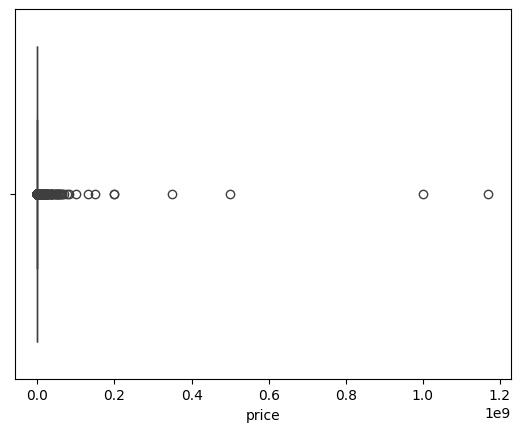

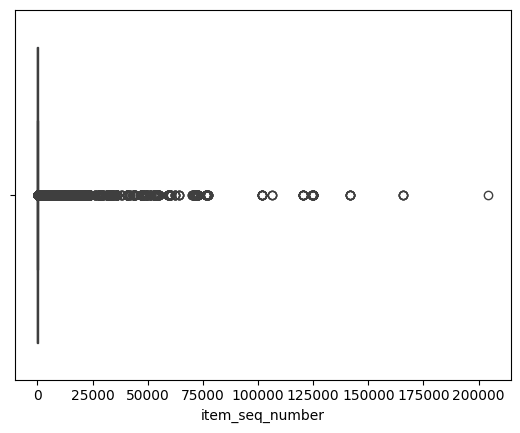

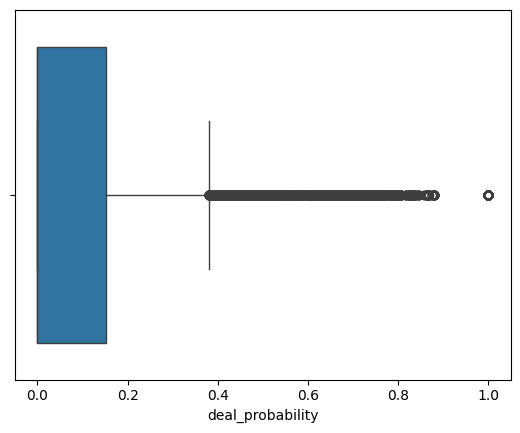

In [11]:
for i in data.columns:
    if data[i].dtypes!=object and len(data[i].value_counts().index)>2:
        sns.boxplot(data=data,x=data[i])
        plt.show()

In [12]:
q1 = data.quantile(0.25, numeric_only=True)
q3 = data.quantile(0.75, numeric_only=True)
IQR = q3-q1

Lower = q1-1.5*IQR
Upper = q3+1.5*IQR

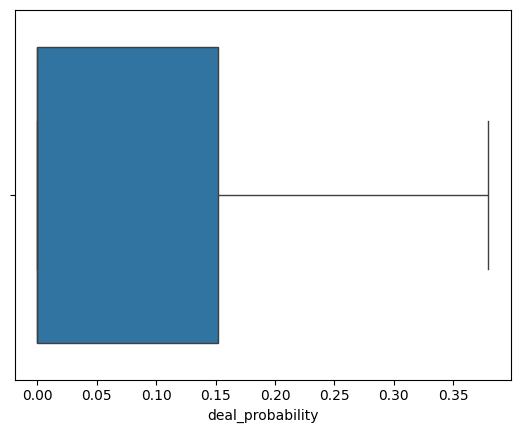

In [13]:
    if data[i].dtypes!=object and len(data[i].value_counts().index)>2:
        data[i] = np.where(data[i] > Upper[i],Upper[i],data[i])
        data[i] = np.where(data[i] < Lower[i],Lower[i],data[i])
        sns.boxplot(data=data,x=data[i])
        plt.show()

In [14]:
data.select_dtypes('object').apply(pd.Series.nunique)

item_id                 75171
user_id                 66683
region                     28
city                     1129
parent_category_name        9
category_name              47
param_1                   328
param_2                   219
param_3                   555
title                   53567
description             67727
activation_date            15
user_type                   3
dtype: int64

In [15]:
group_map = {
    # Автомобили
    'Toyota': 'Автомобили',
    'Volkswagen': 'Автомобили',
    'Hyundai': 'Автомобили',
    'ВАЗ': 'Автомобили',
    'KIA': 'Автомобили',
    'Chevrolet': 'Автомобили',
    'Mercedes‑Benz': 'Автомобили',

    # Одежда и обувь
    'Верхняя одежда': 'Одежда и обувь',
    'Обувь': 'Одежда и обувь',
    'Платья и юбки': 'Одежда и обувь',
    'Брюки': 'Одежда и обувь',
    'Трикотаж': 'Одежда и обувь',
    'Шапки, варежки, шарфы': 'Одежда и обувь',

    # Техника и электроника
    'Стиральные машины': 'Техника и электроника',
    'Холодильники и морозильные камеры': 'Техника и электроника',
    'Видеокарты': 'Техника и электроника',
    'Процессоры': 'Техника и электроника',
    'Микроволновые печи': 'Техника и электроника',

    # Дом и ремонт
    'Дом': 'Дом и ремонт',
    'Поселений (ИЖС)': 'Дом и ремонт',
    'Строительство домов, коттеджей': 'Дом и ремонт',
    'Отделочные работы': 'Дом и ремонт',
    'Дача': 'Дом и ремонт',

    # Детские товары и игрушки
    'Товары для детей': 'Детские товары и игрушки',
    'Игрушки': 'Детские товары и игрушки',
    'Комбинезоны и боди': 'Детские товары и игрушки',

    # Услуги и бизнес
    'Аренда авто': 'Услуги и бизнес',
    'Маркетинг, реклама, PR': 'Услуги и бизнес',
    'Коммерческие перевозки': 'Услуги и бизнес',

    # Другие товары
    'Другое': 'Другие товары',
    # можно добавить остальные в группу “Другие товары”
}


data['param_2_grouped'] = data['param_2'].map(group_map).fillna('Другие товары')

In [16]:

categories_grouped = {
    "Одежда и мода": [
        "Женская одежда","Мужская одежда","Для девочек","Для мальчиков","Аксессуары",
        "Декоративные изделия","Ювелирные изделия","Парфюмерия"
    ],
    "Красота и личный уход": [
        "Средства для волос","Средства гигиены","Косметика","Для салонов красоты",
        "Для индивидуального ухода"
    ],
    "Дети и семья": [
        "Детские коляски","Игрушки","Детская мебель","Товары для кормления","Автомобильные кресла",
        "Товары для купания","Няни и сиделки","Игры с мячом","Игры для приставок"
    ],
    "Дом и мебель": [
        "Кровати, диваны и кресла","Шкафы и комоды","Столы и стулья","Для кухни",
        "Кухонные гарнитуры","Для дома","Предметы интерьера и искусство","Освещение",
        "Постельные принадлежности","Текстиль и ковры","Камины и обогреватели","Уборка"
    ],
    "Электроника и техника": [
        "iPhone","Samsung","Sony","Lenovo","Nokia","Asus","Xiaomi","Fly","Microsoft",
        "Meizu","ZTE","BlackBerry","Motorola","DEXP","Explay","Huawei",
        "Принтеры","Мониторы","Видео, DVD и Blu-ray плееры","Видеокамеры",
        "Фото и видеосъёмка","Зеркальные фотоаппараты","Компактные фотоаппараты",
        "Плёночные фотоаппараты","Объективы","Усилители и ресиверы",
        "Акустика, колонки, сабвуферы","Наушники","Клавиатуры и мыши",
        "Сетевое оборудование","МФУ, копиры и сканеры","Компьютерные столы и кресла"
    ],
    "Транспорт и спорт": [
        "Мотоциклы","Мопеды и скутеры","Грузовики","Трактора","Прицепы","Лёгкий транспорт",
        "Каяки и каноэ","Катера и яхты","Моторные лодки","Снегоходы",
        "Велосипеды и скейтбординг","Ролики и скейтбординг","Зимние виды спорта",
        "Фитнес и тренажёры","BMX","Спорт","Единоборства","Теннис, бадминтон, пинг-понг",
        "Бильярд и боулинг","Пейнтбол и страйкбол"
    ],
    "Животные и экзотика": [
        "С/х животные","Кролики","Грызуны","Сибирский хаски","Немецкая овчарка",
        "Йоркширский терьер","Мейн-кун","Бигль","Той-терьер","Курильский бобтейл",
        "Французский бульдог","Чихуахуа","Овчарка","Бенгальская","Турецкая ангора",
        "Канадский сфинкс","Аляскинский маламут","Шпиц","Шелти"
    ],
    "Другое / Разное": [
        "NaN","Продам","Сдам","Другое","Другая","Обучение, курсы","Для магазина",
        "Для ресторана","Торговля","Марки","Документы","Разное","Реклама, полиграфия"
    ]
}

group_map = {item: group for group, items in categories_grouped.items() for item in items}

data['param_1_grouped'] = data['param_1'].map(group_map).fillna('Другие товары')

data


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability,param_2_grouped,param_1_grouped
20008,1d32ffe80550,f39abf77014f,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Другое,Unknown,Детские вещи пакетом,Отдам детские вещи пакетом 300 руб.размер от 6...,300.000000,10,2017-03-21,Private,0.00000,Другие товары,Одежда и мода
446970,c13b2c8a268e,1671b7e366e4,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,40,Сапоги,Зимние сапоги. Замш. На платформе... торг уместен,1500.000000,14,2017-03-25,Private,0.00000,Одежда и обувь,Одежда и мода
623076,627594210093,43aebc5caa96,Свердловская область,Екатеринбург,Хобби и отдых,Спорт и отдых,Другое,Обувь,Unknown,Брюки для бальных танцев,"Рост-90 см, обхват талии- 66 см",700.000000,5,2017-03-19,Private,0.00000,Одежда и обувь,Другое / Разное
283909,ea7601e8a8df,d30fdae30c67,Татарстан,Казань,Личные вещи,Часы и украшения,Бижутерия,Обувь,Unknown,Подставка для украшений,Продам бархатные подставки для украшений./\n9 ...,250.000000,20,2017-03-27,Private,0.00000,Одежда и обувь,Другие товары
340096,aa402705019b,c918b748b302,Кемеровская область,Новокузнецк,Для дома и дачи,Ремонт и строительство,Стройматериалы,Обувь,Unknown,Дом из бруса с верандой (6х6) м +2м,"Одноэтажный дом с жилым чердачным этажем, одно...",136300.000000,32,2017-03-22,Company,0.37965,Одежда и обувь,Другие товары
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101577,32505edaf3a0,e0f91531f503,Пермский край,Пермь,Хобби и отдых,Книги и журналы,Учебная литература,Обувь,Unknown,Химия книга,В отличном состоянии,100.000000,59,2017-03-21,Company,0.00000,Одежда и обувь,Другие товары
523166,c417bfffe4c5,6efaf97581c4,Ростовская область,Шахты,Личные вещи,Детская одежда и обувь,Для девочек,Комбинезоны и боди,86-92 см (1-2 года),Комбинезон зимний,Комбинезон зимний для девочки серый.,200.000000,31,2017-03-21,Private,0.00000,Детские товары и игрушки,Одежда и мода
579704,23391bf2fbb8,ec05047cd779,Омская область,Омск,Услуги,Предложение услуг,Другое,Обувь,Unknown,Ремонт автопластика,от 300 рублей ремонт зеркал,279917.795491,7,2017-03-17,Private,0.00000,Одежда и обувь,Другое / Разное
445916,2b5d7b2f9cc5,6657c0ffdc22,Челябинская область,Челябинск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,Обувь,Unknown,Палантин,Размеры 176*110,300.000000,13,2017-03-19,Private,0.00000,Одежда и обувь,Одежда и мода


In [17]:
real_estate = [
    'Кирпичный', 'Новостройка', 'На длительный срок', 'За городом',
    'Металлический', 'Студия', 'В черте города', 'Подземный паркинг',
    'Вторичка'
]

locations = ['Азербайджан']

def group_param(x):
    x = str(x)
    
    if x.lower() == 'unknown':  
        return 'Other'
    if x in real_estate:
        return 'Real Estate'
    if x in locations:
        return 'Location'
    if re.search(r'\d', x) or 'см' in x or '<' in x or '>' in x or 'Без размера' in x:
        return 'Size'
    if re.search(r'^(21\d{2}|210\d)', x) or re.search(r'[A-Za-z]', x):
        return 'Car'
    return 'Other'


data['param_3_grouped'] = data['param_3'].apply(group_param)

In [18]:

data = data.reset_index(drop=True)

freq      = data['category_name'].value_counts()
threshold = 150   
rare      = freq[freq < threshold].index
data['category_grp'] = data['category_name'].apply(lambda x: 'Other' if x in rare else x)

global_mean = data['deal_probability'].mean()
m           = 200  

kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_vals = np.zeros(len(data))

for train_idx, val_idx in kf.split(data):
    train = data.iloc[train_idx]
    means  = train.groupby('category_grp')['deal_probability'].mean()
    counts = train.groupby('category_grp')['deal_probability'].count()
    smooth = (counts * means + m * global_mean) / (counts + m)
    smooth_dict = smooth.to_dict()
    
    encoded_vals[val_idx] = data.loc[val_idx, 'category_grp'].map(
        lambda x: smooth_dict.get(x, global_mean)
    )

data['category_encoded'] = encoded_vals


data['category_popularity']  = data.groupby('category_grp')['item_id'].transform('count')


In [19]:
top15 = data['city'].value_counts().nlargest(15).index
data['city_grouped'] = data['city'].where(data['city'].isin(top15), other='Other')
data['region_activity'] = data.groupby('region')['item_id'].transform('count')
data['desc_length'] = data['description'].astype(str).apply(len)

data['activation_date'] = pd.to_datetime(data['activation_date'])
data['act_year']    = data['activation_date'].dt.year
data['act_month']   = data['activation_date'].dt.month
data['act_weekday'] = data['activation_date'].dt.weekday  


In [20]:
cols_to_drop = ['category_name', 'user_id', 'item_id', 'activation_date', 'title', 'description', 'city', 'region', 'param_1', 'param_2', 'param_3']
data = data.drop(columns=cols_to_drop, axis=1)
data


,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,Личные вещи,300.000000,10,Private,0.00000,Другие товары,Одежда и мода,Other,Детская одежда и обувь,0.040007,13419,Нижний Новгород,3600,53,2017,3,1
1,Личные вещи,1500.000000,14,Private,0.00000,Одежда и обувь,Одежда и мода,Size,"Одежда, обувь, аксессуары",0.032157,14103,Саратов,2514,49,2017,3,5
2,Хобби и отдых,700.000000,5,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Спорт и отдых,0.085322,1201,Екатеринбург,4723,31,2017,3,6
3,Личные вещи,250.000000,20,Private,0.00000,Одежда и обувь,Другие товары,Other,Часы и украшения,0.055220,739,Казань,4125,50,2017,3,0
4,Для дома и дачи,136300.000000,32,Company,0.37965,Одежда и обувь,Другие товары,Other,Ремонт и строительство,0.089610,2942,Other,2225,944,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,Хобби и отдых,100.000000,59,Company,0.00000,Одежда и обувь,Другие товары,Other,Книги и журналы,0.048417,643,Пермь,3165,20,2017,3,1
75167,Личные вещи,200.000000,31,Private,0.00000,Детские товары и игрушки,Одежда и мода,Size,Детская одежда и обувь,0.039941,13419,Other,4437,36,2017,3,1
75168,Услуги,279917.795491,7,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Предложение услуг,0.233012,3218,Омск,2155,27,2017,3,4
75169,Личные вещи,300.000000,13,Private,0.00000,Одежда и обувь,Одежда и мода,Other,"Одежда, обувь, аксессуары",0.031860,14103,Челябинск,3946,15,2017,3,6


In [21]:
def target_correlation(data, target, threshold=0.1):
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target

target_result = target_correlation(data, 'deal_probability')

target_result

,Variable,Correlation with Target
0,price,0.227555
1,item_seq_number,-0.176377
2,category_encoded,0.403314
3,category_popularity,-0.254497
4,desc_length,0.103394


In [22]:
def intercorrelation(data, target, threshold=0.7):
    corr_matrix = data.drop(columns=[target]).corr(method='spearman', numeric_only=True)
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    result_intercorrelated_independent = pd.DataFrame({
        'Variable 1': corr_matrix.index[independent_variable_pairs[0]],
        'Variable 2': corr_matrix.columns[independent_variable_pairs[1]]
    })
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data, 'deal_probability')

intercorrelated_result

,Variable 1,Variable 2


In [23]:
target_result.Variable.tolist()

['price',
 'item_seq_number',
 'category_encoded',
 'category_popularity',
 'desc_length']

In [24]:

def calculate_vif(data, variables):
    vif_data = data[variables]
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    vif_result = pd.DataFrame({'VIF': vif_values, 'Features': variables})
    return vif_result


vif_result = calculate_vif(data, [
'price',
 'item_seq_number',
 'category_encoded',
 'category_popularity',
 'desc_length'
 
])

vif_result

,VIF,Features
0,1.004677,price
1,1.037619,item_seq_number
2,1.586534,category_encoded
3,1.221789,category_popularity
4,1.438854,desc_length


In [25]:
targets = data['deal_probability']

inputs = data.drop(['deal_probability'],axis=1)

In [26]:
data

,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,Личные вещи,300.000000,10,Private,0.00000,Другие товары,Одежда и мода,Other,Детская одежда и обувь,0.040007,13419,Нижний Новгород,3600,53,2017,3,1
1,Личные вещи,1500.000000,14,Private,0.00000,Одежда и обувь,Одежда и мода,Size,"Одежда, обувь, аксессуары",0.032157,14103,Саратов,2514,49,2017,3,5
2,Хобби и отдых,700.000000,5,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Спорт и отдых,0.085322,1201,Екатеринбург,4723,31,2017,3,6
3,Личные вещи,250.000000,20,Private,0.00000,Одежда и обувь,Другие товары,Other,Часы и украшения,0.055220,739,Казань,4125,50,2017,3,0
4,Для дома и дачи,136300.000000,32,Company,0.37965,Одежда и обувь,Другие товары,Other,Ремонт и строительство,0.089610,2942,Other,2225,944,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,Хобби и отдых,100.000000,59,Company,0.00000,Одежда и обувь,Другие товары,Other,Книги и журналы,0.048417,643,Пермь,3165,20,2017,3,1
75167,Личные вещи,200.000000,31,Private,0.00000,Детские товары и игрушки,Одежда и мода,Size,Детская одежда и обувь,0.039941,13419,Other,4437,36,2017,3,1
75168,Услуги,279917.795491,7,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Предложение услуг,0.233012,3218,Омск,2155,27,2017,3,4
75169,Личные вещи,300.000000,13,Private,0.00000,Одежда и обувь,Одежда и мода,Other,"Одежда, обувь, аксессуары",0.031860,14103,Челябинск,3946,15,2017,3,6


In [27]:
data = pd.get_dummies(data, drop_first=True)

data

,price,item_seq_number,deal_probability,category_encoded,category_popularity,region_activity,desc_length,act_year,act_month,act_weekday,...,city_grouped_Красноярск,city_grouped_Нижний Новгород,city_grouped_Новосибирск,city_grouped_Омск,city_grouped_Пермь,city_grouped_Ростов-на-Дону,city_grouped_Самара,city_grouped_Саратов,city_grouped_Уфа,city_grouped_Челябинск
0,300.000000,10,0.00000,0.040007,13419,3600,53,2017,3,1,...,False,True,False,False,False,False,False,False,False,False
1,1500.000000,14,0.00000,0.032157,14103,2514,49,2017,3,5,...,False,False,False,False,False,False,False,True,False,False
2,700.000000,5,0.00000,0.085322,1201,4723,31,2017,3,6,...,False,False,False,False,False,False,False,False,False,False
3,250.000000,20,0.00000,0.055220,739,4125,50,2017,3,0,...,False,False,False,False,False,False,False,False,False,False
4,136300.000000,32,0.37965,0.089610,2942,2225,944,2017,3,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,100.000000,59,0.00000,0.048417,643,3165,20,2017,3,1,...,False,False,False,False,True,False,False,False,False,False
75167,200.000000,31,0.00000,0.039941,13419,4437,36,2017,3,1,...,False,False,False,False,False,False,False,False,False,False
75168,279917.795491,7,0.00000,0.233012,3218,2155,27,2017,3,4,...,False,False,False,True,False,False,False,False,False,False
75169,300.000000,13,0.00000,0.031860,14103,3946,15,2017,3,6,...,False,False,False,False,False,False,False,False,False,True


In [28]:
targets = data['deal_probability']

inputs = data.drop(['deal_probability'],axis=1)

In [29]:
scaler = StandardScaler()
scaler.fit(inputs)

scaled = scaler.transform(inputs)

inputs_scaled = pd.DataFrame(scaled, columns=inputs.columns)

inputs_scaled

,price,item_seq_number,category_encoded,category_popularity,region_activity,desc_length,act_year,act_month,act_weekday,parent_category_name_Для бизнеса,...,city_grouped_Красноярск,city_grouped_Нижний Новгород,city_grouped_Новосибирск,city_grouped_Омск,city_grouped_Пермь,city_grouped_Ростов-на-Дону,city_grouped_Самара,city_grouped_Саратов,city_grouped_Уфа,city_grouped_Челябинск
0,-4.419547e-02,-0.131871,-0.911323,1.220271,0.186597,-0.441405,0.0,0.0,-0.962688,-0.109833,...,-0.158844,5.301151,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
1,-4.400580e-02,-0.131151,-1.063475,1.341843,-0.511756,-0.455438,0.0,0.0,1.009855,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,6.744475,-0.166892,-0.183782
2,-4.413224e-02,-0.132770,-0.032906,-0.951316,0.908743,-0.518583,0.0,0.0,1.502991,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
3,-4.420337e-02,-0.130072,-0.616418,-1.033430,0.524199,-0.451929,0.0,0.0,-1.455823,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
4,-2.269975e-02,-0.127913,0.050215,-0.641876,-0.697598,2.684313,0.0,0.0,-0.469552,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,-4.422708e-02,-0.123056,-0.748299,-1.050493,-0.093130,-0.557173,0.0,0.0,-0.962688,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,5.570327,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75167,-4.421127e-02,-0.128093,-0.912588,1.220271,0.724831,-0.501043,0.0,0.0,-0.962688,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75168,9.200111e-18,-0.132411,2.829968,-0.592821,-0.742612,-0.532616,0.0,0.0,0.516720,-0.109833,...,-0.158844,-0.188638,-0.197752,5.933763,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75169,-4.419547e-02,-0.131331,-1.069231,1.341843,0.409093,-0.574713,0.0,0.0,1.502991,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,5.441239


In [30]:
X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=42)

In [31]:
def create_model(trial):

    model = Sequential()

    model.add(Dense(units=trial.suggest_int('units_layer1', 6, 32), activation='relu'))
    model.add(Dense(units=trial.suggest_int('units_layer2', 6, 32), activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

    
    return model

In [32]:
def optimal(trial):

    epochs = trial.suggest_int('epochs', 20, 100 )
    batch_size = trial.suggest_int('batch_size', 16, 64)
    
    model = create_model(trial)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(optimal, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-11-10 12:31:57,770] A new study created in memory with name: no-name-16951871-accd-496c-9701-7dcc36c62dba
C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 2/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 3/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 4/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 5/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 6/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 7/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 8/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 9/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 10/29
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 11/

[I 2025-11-10 12:34:24,897] Trial 0 finished with value: -0.39828856792735734 and parameters: {'epochs': 29, 'batch_size': 54, 'units_layer1': 23, 'units_layer2': 20, 'optimizer': 'adam', 'learning_rate': 0.009006186742300186}. Best is trial 0 with value: -0.39828856792735734.


Epoch 1/25


C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2615/2615 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0897 - mean_absolute_error: 0.0897
Epoch 2/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0878 - mean_absolute_error: 0.0878
Epoch 3/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0875 - mean_absolute_error: 0.0875
Epoch 4/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0866 - mean_absolute_error: 0.0866
Epoch 5/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0859 - mean_absolute_error: 0.0859
Epoch 6/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0846 - mean_absolute_error: 0.0846
Epoch 19/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0814 - mean_absolute_error: 0.0814
Epoch 20/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0805 - mean_absolute_error: 0.0805
Epoch 21/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0802 - mean_absolute_error: 0.0802
Epoch 22/25
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0800 - mean_absolute_error: 0.0800
Epoch 23/2

[I 2025-11-10 12:38:35,053] Trial 1 finished with value: -0.17374993394130733 and parameters: {'epochs': 25, 'batch_size': 23, 'units_layer1': 25, 'units_layer2': 18, 'optimizer': 'rmsprop', 'learning_rate': 0.00021297499907224133}. Best is trial 1 with value: -0.17374993394130733.


Epoch 1/33


C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


1467/1467 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1092 - mean_absolute_error: 0.1092
Epoch 2/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0859 - mean_absolute_error: 0.0859
Epoch 3/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 4/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0848 - mean_absolute_error: 0.0848
Epoch 5/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0846 - mean_absolute_error: 0.0846
Epoch 6/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0844 - mean_absolute_error: 0.0844
Epoch 7/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0843 - mean_absolute_error: 0.0843
Epoch 8/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0842 - mean_absolute_error: 0.0842
Epoch 9/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0842 - mean_absolute_error: 0.0842
Epoch 10/33
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0841 - mean_absolute_error: 0.0841
Epoch 11/33
14

[I 2025-11-10 12:42:35,711] Trial 2 finished with value: -0.2699192686681129 and parameters: {'epochs': 33, 'batch_size': 41, 'units_layer1': 29, 'units_layer2': 24, 'optimizer': 'rmsprop', 'learning_rate': 6.15086003979142e-05}. Best is trial 1 with value: -0.17374993394130733.
C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1105 - mean_absolute_error: 0.1105
Epoch 2/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0886 - mean_absolute_error: 0.0886
Epoch 3/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0884 - mean_absolute_error: 0.0884
Epoch 4/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0849 - mean_absolute_error: 0.0849
Epoch 5/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0838 - mean_absolute_error: 0.0838
Epoch 6/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0834 - mean_absolute_error: 0.0834
Epoch 7/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0833 - mean_absolute_error: 0.0833
Epoch 8/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0825 - mean_absolute_error: 0.0825
Epoch 9/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0807 - mean_absolute_error: 0.0807
Epoch 10/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0800 - mean_absolute_error: 0.0800
Epoch 11/

[I 2025-11-10 12:46:51,887] Trial 3 finished with value: -0.09013616397346724 and parameters: {'epochs': 52, 'batch_size': 52, 'units_layer1': 28, 'units_layer2': 31, 'optimizer': 'adam', 'learning_rate': 0.00038928518059398254}. Best is trial 3 with value: -0.09013616397346724.
C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0970 - mean_absolute_error: 0.0970
Epoch 2/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 3/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0846 - mean_absolute_error: 0.0846
Epoch 4/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0843 - mean_absolute_error: 0.0843
Epoch 5/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0841 - mean_absolute_error: 0.0841
Epoch 6/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0840 - mean_absolute_error: 0.0840
Epoch 7/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0837 - mean_absolute_error: 0.0837
Epoch 8/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0834 - mean_absolute_error: 0.0834
Epoch 9/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833
Epoch 10/99
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833
Epoch 11/

[I 2025-11-10 12:54:39,734] Trial 4 finished with value: -0.16354878817812768 and parameters: {'epochs': 99, 'batch_size': 54, 'units_layer1': 6, 'units_layer2': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0002677645037740845}. Best is trial 3 with value: -0.09013616397346724.
C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1588 - mean_absolute_error: 0.1588
Epoch 2/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1166 - mean_absolute_error: 0.1166
Epoch 23/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1160 - mean_absolute_error: 0.1160
Epoch 24/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1154 - mean_absolute_error: 0.1154
Epoch 25/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1148 - mean_absolute_error: 0.1148
Epoch 26/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1143 - mean_absolute_error: 0.1143
Epoch 27/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1138 - mean_absolute_error: 0.1138
Epoch 28/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1133 - mean_absolute_error: 0.1133
Epoch 29/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1128 - mean_absolute_error: 0.1128
Epoch 30/75
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1123 - mean_absolute_error: 0.1123
Ep

[I 2025-11-10 13:00:20,355] Trial 5 finished with value: -0.7353741079337717 and parameters: {'epochs': 75, 'batch_size': 60, 'units_layer1': 18, 'units_layer2': 23, 'optimizer': 'adagrad', 'learning_rate': 3.619947798834176e-05}. Best is trial 3 with value: -0.09013616397346724.
C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0939 - mean_absolute_error: 0.0939
Epoch 2/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0895 - mean_absolute_error: 0.0895
Epoch 3/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0891 - mean_absolute_error: 0.0891
Epoch 4/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 5/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0888 - mean_absolute_error: 0.0888
Epoch 6/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0887 - mean_absolute_error: 0.0887
Epoch 7/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0885 - mean_absolute_error: 0.0885
Epoch 8/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0884 - mean_absolute_error: 0.0884
Epoch 9/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0883 - mean_absolute_error: 0.0883
Epoch 10/70
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0882 - mean_absolute_error: 0.0882
Epoch 11/

[I 2025-11-10 13:06:10,124] Trial 6 finished with value: -0.3545966033746437 and parameters: {'epochs': 70, 'batch_size': 45, 'units_layer1': 24, 'units_layer2': 8, 'optimizer': 'rmsprop', 'learning_rate': 2.0478810915246054e-05}. Best is trial 3 with value: -0.09013616397346724.


Epoch 1/21


C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


1337/1337 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1909 - mean_absolute_error: 0.1909
Epoch 2/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1795 - mean_absolute_error: 0.1795
Epoch 3/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1728 - mean_absolute_error: 0.1728
Epoch 4/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1678 - mean_absolute_error: 0.1678
Epoch 5/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1639 - mean_absolute_error: 0.1639
Epoch 6/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1606 - mean_absolute_error: 0.1606
Epoch 7/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1578 - mean_absolute_error: 0.1578
Epoch 8/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1553 - mean_absolute_error: 0.1553
Epoch 9/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1530 - mean_absolute_error: 0.1530
Epoch 10/21
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1510 - mean_absolute_error: 0.1510
Epoch 11/21
1337/133

[I 2025-11-10 13:07:57,605] Trial 7 finished with value: -2.20860468935887 and parameters: {'epochs': 21, 'batch_size': 45, 'units_layer1': 11, 'units_layer2': 6, 'optimizer': 'adagrad', 'learning_rate': 6.885265640980623e-05}. Best is trial 3 with value: -0.09013616397346724.


Epoch 1/40


C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1137 - mean_absolute_error: 0.1137
Epoch 2/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0914 - mean_absolute_error: 0.0914
Epoch 3/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0898 - mean_absolute_error: 0.0898
Epoch 4/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0894 - mean_absolute_error: 0.0894
Epoch 5/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0892 - mean_absolute_error: 0.0892
Epoch 6/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0891 - mean_absolute_error: 0.0891
Epoch 7/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0891 - mean_absolute_error: 0.0891
Epoch 8/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0890 - mean_absolute_error: 0.0890
Epoch 9/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0890 - mean_absolute_error: 0.0890
Epoch 10/40
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0890 - mean_absolute_error: 0.0890
Epoch 11/40
970/970 ━━━━━━━━━━━━━━━━━━━━

[I 2025-11-10 13:10:58,653] Trial 8 finished with value: -0.39467997289147894 and parameters: {'epochs': 40, 'batch_size': 62, 'units_layer1': 17, 'units_layer2': 20, 'optimizer': 'adagrad', 'learning_rate': 0.0008536087432086531}. Best is trial 3 with value: -0.09013616397346724.


Epoch 1/92


C:\Users\user\AppData\Local\Temp\ipykernel_15392\2512438285.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


1432/1432 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3350 - mean_absolute_error: 0.3350
Epoch 2/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2876 - mean_absolute_error: 0.2876
Epoch 3/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2599 - mean_absolute_error: 0.2599
Epoch 4/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2394 - mean_absolute_error: 0.2394
Epoch 5/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2229 - mean_absolute_error: 0.2229
Epoch 6/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2094 - mean_absolute_error: 0.2094
Epoch 7/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1981 - mean_absolute_error: 0.1981
Epoch 8/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1882 - mean_absolute_error: 0.1882
Epoch 9/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1796 - mean_absolute_error: 0.1796
Epoch 10/92
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1721 - mean_absolute_error: 0.1721
Epoch 11/92
1432/

[I 2025-11-10 13:19:40,310] Trial 9 finished with value: -0.497454091221174 and parameters: {'epochs': 92, 'batch_size': 42, 'units_layer1': 13, 'units_layer2': 32, 'optimizer': 'adagrad', 'learning_rate': 4.493415514083186e-05}. Best is trial 3 with value: -0.09013616397346724.


Best trial: -0.09013616397346724
Best hyperparameters: {'epochs': 52, 'batch_size': 52, 'units_layer1': 28, 'units_layer2': 31, 'optimizer': 'adam', 'learning_rate': 0.00038928518059398254}


In [ ]:
best_params = study.best_trial.params

best_params

{'epochs': 52,
 'batch_size': 52,
 'units_layer1': 28,
 'units_layer2': 31,
 'optimizer': 'adam',
 'learning_rate': 0.00038928518059398254}

In [ ]:
best_model = Sequential()
best_model.add(Dense(units=best_params['units_layer1'], activation='relu'))
best_model.add(Dense(units=best_params['units_layer2'], activation='relu'))
best_model.add(Dense(1, activation='relu'))

In [ ]:
if best_params['optimizer'] == 'adam':
    best_optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    best_optimizer = SGD(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'rmsprop':
    best_optimizer = RMSprop(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'adagrad':
    best_optimizer = Adagrad(learning_rate=best_params['learning_rate'])

In [ ]:
best_model.compile(optimizer=best_optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

In [ ]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    results = pd.DataFrame({
        'Metric': ['Train', 'Test'],
        'R2': [r2_train, r2_test],
        'MAE': [mae_train, mae_test]
    })
    
    return results

In [ ]:
evaluate(best_model, X_train, y_train, X_test, y_test)

Epoch 1/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0942 - mean_absolute_error: 0.0942
Epoch 2/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0836 - mean_absolute_error: 0.0836
Epoch 3/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0833 - mean_absolute_error: 0.0833
Epoch 4/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0826 - mean_absolute_error: 0.0826
Epoch 5/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0816 - mean_absolute_error: 0.0816
Epoch 6/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0813 - mean_absolute_error: 0.0813
Epoch 7/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0807 - mean_absolute_error: 0.0807
Epoch 8/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0797 - mean_absolute_error: 0.0797
Epoch 9/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0794 - mean_absolute_error: 0.0794
Epoch 10/52
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0789 - mean_absolute_error: 0.0789
Epoch 11/

,Metric,R2,MAE
0,Train,-0.042828,0.075768
1,Test,-0.099156,0.080546
